# Modelos simples

En este notebook se entrenan los diferentes modelos neuronales simples. En todos los casos se sigue el mismo patrón: carga y división de los datos, generación de la arquitectura del modelo, compilación, entrenamiento, análisis, preparación para inferencia, cuantización y compilación a TFLite.

Los modelos son:

* modelo que utiliza los espectrogramas de Mel
* modelo que utiliza los MFCCs
* modelo que utiliza los datos crudos

Importamos los paquetes que se van a ir utilizando de forma general a lo largo del código.

In [1]:
# General libraries
import numpy as np
import pandas as pd
import random
random.seed(1997)
import os
import shutil
import json
import re

from tqdm import tqdm

# ML and AI
import tensorflow as tf
import keras
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Graphics and plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import plotly.express as px

# Audio specifics
import IPython
import wave
import soundfile as sf
from pydub import AudioSegment
import librosa
import librosa.display

Definimos las variables globales.

In [2]:
# Global variables - Paths
RAW_PATH = "./data/raw"
RAW_SPEECH_PATH = os.path.join(RAW_PATH, "speech_commands").replace("\\","/")

JSON_PATH = "./data/json"

MODEL_PATH = "./models/Simple_models/"

# Global variables - Others
COMMON_NFRAMES_LIBROSA = 22050
PATIENCE = 5 # epochs to wait until we apply the early stop callback

In [3]:
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

labels = ["00-zero", "01-one", "02-two", "03-three", "04-four", "05-five", "06-six", "07-seven", "08-eight", "09-nine", "10-on", "11-off", "12-up", "13-down", "14-left", "15-right", "16-yes", "17-no"]
if not os.path.exists(os.path.join(MODEL_PATH, "labels.txt").replace("\\", "/")):
    with open(os.path.join(MODEL_PATH, "labels.txt").replace("\\", "/"), "w") as fp:
        for i, label in enumerate(labels):
            if i != len(labels)-1:
                fp.write(f"{label}\n")
            else:
                fp.write(f"{label}")

# Modelos simples

En esta parte del trabajo vamos a elaborar diversas redes neuronales sencillas para abordar el problema de la clasificación de los comandos de voz. Las redes que desarrollemos serán diferentes, ya que cada una estará adaptada al tipo de datos transformado o preprocesado.

Concretamente, vamos a desarrollar modelos para resolver el problema de 3 formas diferentes:

* en primer lugar crearemos una red de capas convolucionales para abordar el problema utilizando los espectrogramas de Mel. Tomaremos los espectrogramas como imágenes a analizar por la CNN
* posteriormente, repetiremos este mismo planteamiento con otra red de capas convolucionales abordando el problema utilizando los MFCCs. Como podemos entenderlos como un tipo de espectrogramas en un espacio diferente, los entenderemos como imágenes y los analizaremos como tal
* por último crearemos otra red de capas convolucionales (esta vez 1D) para abordar el problema utilizando directamente los datos crudos de la señal digitilizada -> en un primer momento se intento enfocar esta parte del problema utilizando una red de capas densas con la posibilidad de incluir capas recurrentes LSTM, pero o bien el conjunto de datos sobreajustaba demasiado o el entrenamiento era excesivamente largo y con malos resultados

Por último, en cada caso transformaremos el modelo final escogido en un modelo TFLite habiendo cuantizado completamente las activaciones y los pesos a enteros para poder desplegarlos en la TPU. En cada caso explicaremos el proceso seguido ya que la idea es generar un modelo preparado para ser cuantizado (diferente de la post-cuantización), y para cada modelo TFLite generado compararemos los valores del accuracy obtenidos para los diferentes conjuntos de entrenamiento, con el objetivo de analizar si la cuantización y la transformación del modelo en TFLite empeora sus resultados.

*Hay que tener en cuenta que el objetivo final del trabajo es poder poner en funcionamiento el modelo en una TPU, por lo que estamos limitados en cuanto a los tipos de capas que podemos utilizar ya que no todas ellas con cuantizables y transformables en un modelo TFLite.

## 1- Datos como espectrogramas de Mel

Los espectrogramas podemos entenderlos como imágenes que podemos procesar por medio de una red de capas convolucionales, en este caso 2D. Estas capas son mucho más eficientes en relación al número de parámetros que hay que entrenar, así que es el modelo principal escogido para tratar este tipo de datos.

Empezamos cargando los datos que hemos guardado previamente en el archivo json.

In [4]:
with open(os.path.join(JSON_PATH, "data_melspecs.json").replace("\\", "/"), "r") as json_file:
    data_melspecs = json.load(json_file)

X_normal_melspecs = np.array(data_melspecs["melspecs"])
y_normal_melspecs = np.array(data_melspecs["labels"])

with open(os.path.join(JSON_PATH, "data_melspecs_augmented.json").replace("\\", "/"), "r") as json_file:
    data_melspecs_augmented = json.load(json_file)

X_augmented_melspecs = np.array(data_melspecs_augmented["melspecs"])
y_augmented_melspecs = np.array(data_melspecs_augmented["labels"])

labels = [label[0] for label in data_melspecs["mappings"]]

In [5]:
del data_melspecs, data_melspecs_augmented

Como tenemos los conjuntos normales y aumentados separados, tenemos que hacer un breve tratamiento para dividir correctamente los datos en train, validacion y test, teniendo en cuenta que los datos aumentados solo pueden estar en el conjunto de train.

In [6]:
test_size = 0.3
X_train_melspecs, X_test_melspecs, y_train_melspecs, y_test_melspecs = train_test_split(X_normal_melspecs, y_normal_melspecs, test_size=test_size, stratify=y_normal_melspecs)

validation_size = 0.1
X_train_melspecs, X_val_melspecs, y_train_melspecs, y_val_melspecs = train_test_split(X_train_melspecs, y_train_melspecs, test_size=validation_size, stratify=y_train_melspecs)

X_train_melspecs = np.concatenate([X_train_melspecs, X_augmented_melspecs])
y_train_melspecs = np.concatenate([y_train_melspecs, y_augmented_melspecs])

In [7]:
print("Train data:", X_train_melspecs.shape)
print("Train labels:", y_train_melspecs.shape)

print("Validation data:", X_val_melspecs.shape)
print("Validation labels:", y_val_melspecs.shape)

print("Test data:", X_test_melspecs.shape)
print("Test labels:", y_test_melspecs.shape)

Train data: (42099, 44, 80)
Train labels: (42099,)
Validation data: (2838, 44, 80)
Validation labels: (2838,)
Test data: (12161, 44, 80)
Test labels: (12161,)


In [8]:
del X_normal_melspecs, y_normal_melspecs, X_augmented_melspecs, y_augmented_melspecs

Ahora ajustamos las dimensiones para que estas sean coherentes con las dimensiones de entrada de la red neuronal que vamos a entrenar. Como vamos a crear una CNN tenemos que pasarle una secuencia de entrada correspondiente a los datos de la imagen del espectrograma (primeras 2 dimensiones) pero tenemos que añadir una dimensión extra que se refiere al número de canales que tiene la supuesta imagen. En nuestro caso solo tenemos un canal porque no estamos trabajando con una imagen como tal, así que simplemente añadimos esa dimensión.

In [9]:
X_train_melspecs = X_train_melspecs[..., np.newaxis]
X_val_melspecs = X_val_melspecs[..., np.newaxis]
X_test_melspecs = X_test_melspecs[..., np.newaxis]

De este modo, los datos de entrada a la red tienen las siguientes dimensiones: (# muestras por conjunto, # segmentos temporales, # bandas de Mel, # canales = 1). Los conjuntos de las etiquetas tienen una sola dimensión.

Ahora ya podemos pasar a construir la CNN que queremos entrenar.

### CNN normal (sin cuantizar)

Creamos una red basada en capas convolucionales. A la hora de crear el modelo tenemos en cuenta solo las capas que se pueden cuantizar, así que capas como por ejemplo la de BatchNormalization no se pueden utilizar.

In [11]:
input_shape = (X_train_melspecs.shape[1], X_train_melspecs.shape[2], X_train_melspecs.shape[3])
num_labels = len(np.unique(y_train_melspecs))

model_CNN_melspecs = keras.Sequential()

# 1st convolutional layer
model_CNN_melspecs.add(keras.layers.Conv2D(32, (3,3), input_shape=input_shape, activation="relu"))
model_CNN_melspecs.add(keras.layers.MaxPool2D((2,2), strides=(1,1), padding="same"))

# 2nd convolutional layer
model_CNN_melspecs.add(keras.layers.Conv2D(16, (3,3), activation="relu"))
model_CNN_melspecs.add(keras.layers.MaxPool2D((2,2), strides=(1,1), padding="same"))

# 3rd convolutional layer
model_CNN_melspecs.add(keras.layers.Conv2D(8, (3,3), activation="relu"))
model_CNN_melspecs.add(keras.layers.MaxPool2D((2,2), strides=(1,1), padding="same"))

# Flatten + Final dense
model_CNN_melspecs.add(keras.layers.Flatten())
model_CNN_melspecs.add(keras.layers.Dense(num_labels, activation="softmax"))

model_CNN_melspecs.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 42, 78, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 78, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 76, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 76, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 74, 8)         1160      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 38, 74, 8)        0

In [12]:
"""
# ALTERNATIVE MODEL

input_shape = (X_train_melspecs.shape[1], X_train_melspecs.shape[2], X_train_melspecs.shape[3])
num_labels = len(np.unique(y_train_melspecs))

model_CNN_melspecs = keras.Sequential()

# 1st convolutional layer
model_CNN_melspecs.add(keras.layers.Conv2D(16, (3,3), input_shape=input_shape, activation="relu"))
model_CNN_melspecs.add(keras.layers.MaxPool2D((2,2), strides=(1,1), padding="same"))

# 2nd convolutional layer
model_CNN_melspecs.add(keras.layers.Conv2D(8, (3,3), activation="relu"))
model_CNN_melspecs.add(keras.layers.MaxPool2D((2,2), strides=(1,1), padding="same"))

# 3rd convolutional layer
model_CNN_melspecs.add(keras.layers.Conv2D(2, (3,3), activation="relu"))
model_CNN_melspecs.add(keras.layers.MaxPool2D((2,2), strides=(1,1), padding="same"))

# 4th convolutional layer
model_CNN_melspecs.add(keras.layers.Conv2D(8, (3,3), activation="relu"))
model_CNN_melspecs.add(keras.layers.MaxPool2D((2,2), strides=(1,1), padding="same"))

# Flatten + Dense + Final dense
model_CNN_melspecs.add(keras.layers.Flatten())
model_CNN_melspecs.add(keras.layers.Dense(16, activation="relu"))
model_CNN_melspecs.add(keras.layers.Dense(num_labels, activation="softmax"))

model_CNN_melspecs.summary()
"""

'\n# ALTERNATIVE MODEL\n\ninput_shape = (X_train_melspecs.shape[1], X_train_melspecs.shape[2], X_train_melspecs.shape[3])\nnum_labels = len(np.unique(y_train_melspecs))\n\nmodel_CNN_melspecs = keras.Sequential()\n\n# 1st convolutional layer\nmodel_CNN_melspecs.add(keras.layers.Conv2D(16, (3,3), input_shape=input_shape, activation="relu"))\nmodel_CNN_melspecs.add(keras.layers.MaxPool2D((2,2), strides=(1,1), padding="same"))\n\n# 2nd convolutional layer\nmodel_CNN_melspecs.add(keras.layers.Conv2D(8, (3,3), activation="relu"))\nmodel_CNN_melspecs.add(keras.layers.MaxPool2D((2,2), strides=(1,1), padding="same"))\n\n# 3rd convolutional layer\nmodel_CNN_melspecs.add(keras.layers.Conv2D(2, (3,3), activation="relu"))\nmodel_CNN_melspecs.add(keras.layers.MaxPool2D((2,2), strides=(1,1), padding="same"))\n\n# 4th convolutional layer\nmodel_CNN_melspecs.add(keras.layers.Conv2D(8, (3,3), activation="relu"))\nmodel_CNN_melspecs.add(keras.layers.MaxPool2D((2,2), strides=(1,1), padding="same"))\n\n# F

In [13]:
plot_model(model_CNN_melspecs, to_file="CNN_melspecs.png", show_shapes=True, show_dtype=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


Compilamos el modelo.

In [14]:
# Compile the model
model_CNN_melspecs.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Entrenamos el modelo compilado.

In [15]:
earlystop_callback = keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=PATIENCE)

hist_CNN_melspecs = model_CNN_melspecs.fit(X_train_melspecs, y_train_melspecs, batch_size=50, epochs=25, validation_data=[X_val_melspecs, y_val_melspecs], verbose=1)

Epoch 1/25
842/842 [==============================] - 226s 267ms/step - loss: 1.5942 - accuracy: 0.5222 - val_loss: 0.8509 - val_accuracy: 0.7417
Epoch 2/25
842/842 [==============================] - 226s 268ms/step - loss: 0.7409 - accuracy: 0.7704 - val_loss: 0.7660 - val_accuracy: 0.7819
Epoch 3/25
842/842 [==============================] - 216s 257ms/step - loss: 0.5350 - accuracy: 0.8327 - val_loss: 0.5635 - val_accuracy: 0.8252
Epoch 4/25
842/842 [==============================] - 216s 257ms/step - loss: 0.4049 - accuracy: 0.8694 - val_loss: 0.4646 - val_accuracy: 0.8633
Epoch 5/25
842/842 [==============================] - 210s 250ms/step - loss: 0.3031 - accuracy: 0.9033 - val_loss: 0.5700 - val_accuracy: 0.8679
Epoch 6/25
842/842 [==============================] - 211s 251ms/step - loss: 0.2312 - accuracy: 0.9257 - val_loss: 0.5276 - val_accuracy: 0.8739
Epoch 7/25
842/842 [==============================] - 209s 248ms/step - loss: 0.1806 - accuracy: 0.9397 - val_loss: 0.6381 -

Mostramos la evolución del loss y el accuracy durante el entrenamiento.

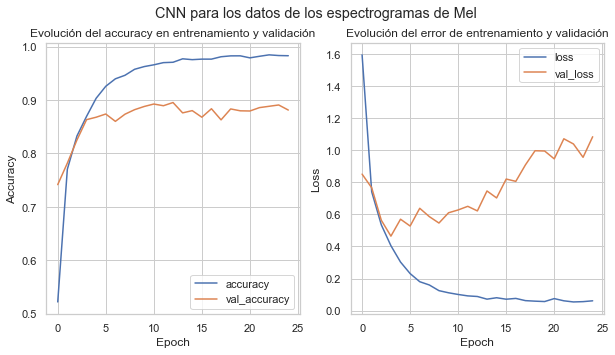

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# accuracy subplot
ax[0].plot(hist_CNN_melspecs.history["accuracy"], label="accuracy")
ax[0].plot(hist_CNN_melspecs.history["val_accuracy"], label="val_accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc="lower right")
ax[0].set_title("Evolución del accuracy en entrenamiento y validación")

# loss subplot
ax[1].plot(hist_CNN_melspecs.history["loss"], label="loss")
ax[1].plot(hist_CNN_melspecs.history["val_loss"], label="val_loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend(loc="upper right")
ax[1].set_title("Evolución del error de entrenamiento y validación")

plt.suptitle("CNN para los datos de los espectrogramas de Mel")
plt.show()

Calculamos el accuracy sobre todos los conjuntos de datos (train, validacion y test) para compararlos entre ellos.

In [17]:
train_loss_CNN_melspecs, train_acc_CNN_melspecs = model_CNN_melspecs.evaluate(X_train_melspecs, y_train_melspecs, verbose=0)
print("Accuracy en train:", train_acc_CNN_melspecs)

Accuracy en train: 0.9881707429885864


In [18]:
val_loss_CNN_melspecs, val_acc_CNN_melspecs = model_CNN_melspecs.evaluate(X_val_melspecs, y_val_melspecs, verbose=0)
print("Accuracy en validación:", val_acc_CNN_melspecs)

Accuracy en validación: 0.8812543749809265


In [19]:
test_loss_CNN_melspecs, test_acc_CNN_melspecs = model_CNN_melspecs.evaluate(X_test_melspecs, y_test_melspecs, verbose=0)
print("Accuracy en test:", test_acc_CNN_melspecs)

Accuracy en test: 0.8850423693656921


Obtenemos unos valores del accuracy bastante elevados, pero vemos que el accuracy en train es mucho mayor que en validación y test, lo que puede indicar un cierto sobreajuste. Sin embargo, el accuracy en test es bastante bueno, así que no nos preocupa del todo.

Mostramos ahora las matrices de confusión.

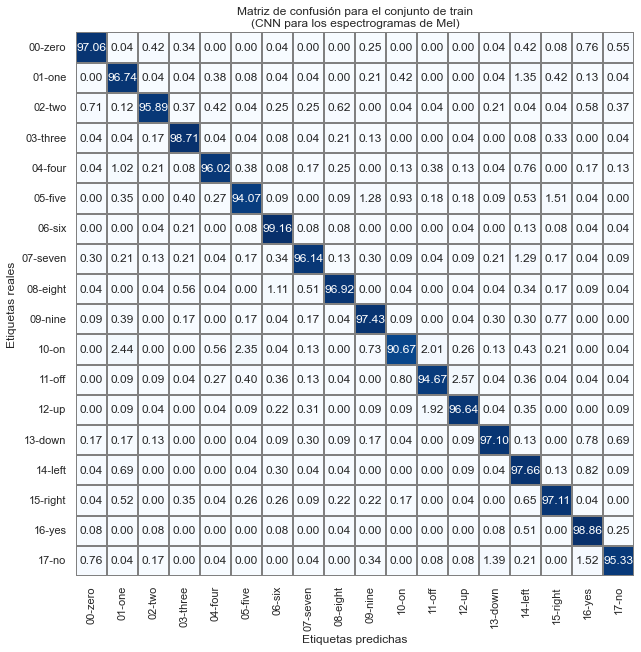

In [11]:
preds_train_CNN_melspecs = model_CNN_melspecs.predict(X_train_melspecs, verbose=0)
preds_indexes_train_CNN_melspecs = [np.argmax(pred) for pred in preds_train_CNN_melspecs]
pos = [i+0.5 for i in range(len(labels))]

confusion_mtx_CNN_melspecs_train = np.around(confusion_matrix(y_train_melspecs, preds_indexes_train_CNN_melspecs, normalize="true")*100, 2)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx_CNN_melspecs_train, annot=True, linewidths=0.01, cmap="Blues", linecolor="gray", fmt=".2f", cbar=False, ax=ax)
plt.xlabel("Etiquetas predichas")
plt.xticks(pos, labels, rotation="vertical")
plt.ylabel("Etiquetas reales")
plt.yticks(pos, labels, rotation="horizontal")
plt.title("Matriz de confusión para el conjunto de train\n(CNN para los espectrogramas de Mel)")

plt.show()

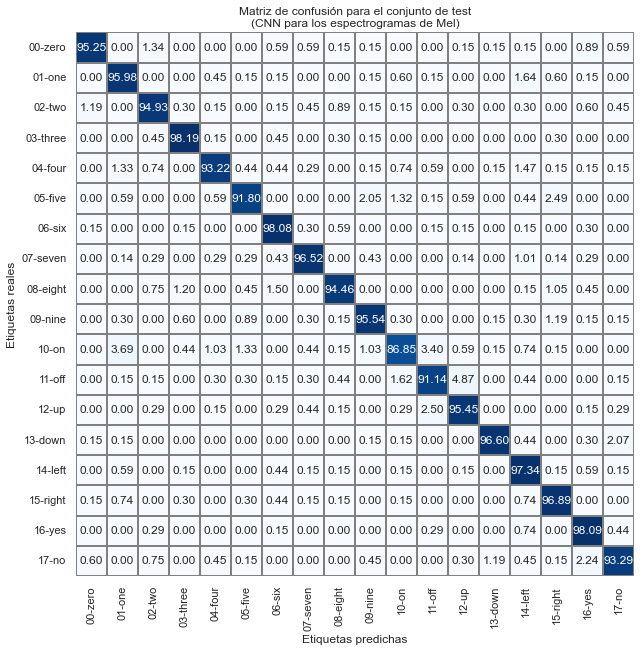

In [12]:
preds_test_CNN_melspecs = model_CNN_melspecs.predict(X_test_melspecs, verbose=0)
preds_indexes_test_CNN_melspecs = [np.argmax(pred) for pred in preds_test_CNN_melspecs]
pos = [i+0.5 for i in range(len(labels))]

confusion_mtx_CNN_melspecs_test = np.around(confusion_matrix(y_test_melspecs, preds_indexes_test_CNN_melspecs, normalize="true")*100, 2)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx_CNN_melspecs_test, annot=True, linewidths=0.01, cmap="Blues", linecolor="gray", fmt=".2f", cbar=False, ax=ax)
plt.xlabel("Etiquetas predichas")
plt.xticks(pos, labels, rotation="vertical")
plt.ylabel("Etiquetas reales")
plt.yticks(pos, labels, rotation="horizontal")
plt.title("Matriz de confusión para el conjunto de test\n(CNN para los espectrogramas de Mel)")

plt.show()

Finalmente, guardamos el modelo que hemos entrenado, en versión normal y en versión tflite.

In [22]:
#Normal
model_CNN_melspecs.save(os.path.join(MODEL_PATH, "CNN_melspecs.h5").replace("\\", "/"))

#TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model_CNN_melspecs)
tflite_model = converter.convert()
with open(os.path.join(MODEL_PATH, "CNN_melspecs.tflite").replace("\\", "/"), "wb") as f:
    f.write(tflite_model)

#### Inferencia

Probamos como llevar a cabo la inferencia en nuevas muestras, obteniendo la predicción para una muestra del conjunto de test.

In [23]:
preds = model_CNN_melspecs.predict(X_test_melspecs[0][np.newaxis, ...], verbose=0)
pred_index = np.argmax(preds)

print("Real:", labels[y_test_melspecs[0]])
print("Prediccion:", labels[pred_index])

Real: 14-left
Prediccion: 14-left


Por otro lado, en caso de que se tratase de un nuevo audio que no ha sido procesado previamente (por ejemplo un audio que llega directamente a través del micrófono), sería necesario transformar la información para poder predecir sobre él.

In [24]:
n_mels=80
hop_length=512
n_fft=2048

for label in labels:

    # Load audio file
    filename = random.choice(os.listdir(os.path.join(RAW_SPEECH_PATH, label).replace("\\", "/")))
    filename = os.path.join(label, filename).replace("\\", "/")
    signal, sample_rate = librosa.load(os.path.join(RAW_SPEECH_PATH, filename).replace("\\", "/"), sr=COMMON_NFRAMES_LIBROSA)

    # Ensure proper length of the audio file
    if len(signal) > COMMON_NFRAMES_LIBROSA:
        signal = signal[:COMMON_NFRAMES_LIBROSA]
    
    # Get Mel spectrogram (in dB)
    melspec = librosa.feature.melspectrogram(signal, sr=sample_rate, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
    melspec_dB = librosa.power_to_db(melspec, ref=np.max)
    melspec_dB = melspec_dB.T # transpose to keep consistency with what the CNN expects (# temporal segments, # Mel bands)

    # Prepare data to be fed into the CNN
    melspec_dB = melspec_dB[np.newaxis, ..., np.newaxis]

    preds = model_CNN_melspecs.predict(melspec_dB, verbose=0)
    pred_index = np.argmax(preds)

    print("Real (por localización del audio):", label)
    print("Prediccion:", labels[pred_index], "\n")

Real (por localización del audio): 00-zero
Prediccion: 00-zero 

Real (por localización del audio): 01-one
Prediccion: 01-one 

Real (por localización del audio): 02-two
Prediccion: 02-two 

Real (por localización del audio): 03-three
Prediccion: 03-three 

Real (por localización del audio): 04-four
Prediccion: 04-four 

Real (por localización del audio): 05-five
Prediccion: 05-five 

Real (por localización del audio): 06-six
Prediccion: 06-six 

Real (por localización del audio): 07-seven
Prediccion: 07-seven 

Real (por localización del audio): 08-eight
Prediccion: 08-eight 

Real (por localización del audio): 09-nine
Prediccion: 09-nine 

Real (por localización del audio): 10-on
Prediccion: 10-on 

Real (por localización del audio): 11-off
Prediccion: 11-off 

Real (por localización del audio): 12-up
Prediccion: 12-up 

Real (por localización del audio): 13-down
Prediccion: 13-down 

Real (por localización del audio): 14-left
Prediccion: 14-left 

Real (por localización del audio): 

### Modelo preparado para cuantizar

Una vez tenemos el modelo ya definido, necesitamos convertirlo en un modelo cuantizado para que se pueda ejecutar en la TPU. Este proceso requiere que generemos y entrenemos un nuevo modelo con la misma estructura que el anterior, pero que esté preparado de antemano para ser cuantizado.

In [25]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware
q_aware_CNN_melspecs = quantize_model(model_CNN_melspecs)

# `quantize_model` requires a recompile
q_aware_CNN_melspecs.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

q_aware_CNN_melspecs.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 44, 80, 1)        3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 42, 78, 32)       387       
 erV2)                                                           
                                                                 
 quant_max_pooling2d (Quanti  (None, 42, 78, 32)       1         
 zeWrapperV2)                                                    
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 40, 76, 16)       4659      
 pperV2)                                                         
                                                                 
 quant_max_pooling2d_1 (Quan  (None, 40, 76, 16)       1

In [26]:
earlystop_callback = keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=PATIENCE)

hist_q_aware_CNN_melspecs = q_aware_CNN_melspecs.fit(X_train_melspecs, y_train_melspecs, batch_size=50, epochs=25, validation_data=[X_val_melspecs, y_val_melspecs], verbose=1)

Epoch 1/25
842/842 [==============================] - 240s 284ms/step - loss: 0.0792 - accuracy: 0.9754 - val_loss: 0.8661 - val_accuracy: 0.8830
Epoch 2/25
842/842 [==============================] - 243s 288ms/step - loss: 0.0496 - accuracy: 0.9857 - val_loss: 0.9233 - val_accuracy: 0.8932
Epoch 3/25
842/842 [==============================] - 243s 288ms/step - loss: 0.0398 - accuracy: 0.9881 - val_loss: 0.9426 - val_accuracy: 0.8922
Epoch 4/25
842/842 [==============================] - 242s 288ms/step - loss: 0.0486 - accuracy: 0.9856 - val_loss: 1.0597 - val_accuracy: 0.8957
Epoch 5/25
842/842 [==============================] - 239s 284ms/step - loss: 0.0618 - accuracy: 0.9835 - val_loss: 1.1881 - val_accuracy: 0.8777
Epoch 6/25
842/842 [==============================] - 248s 295ms/step - loss: 0.0310 - accuracy: 0.9905 - val_loss: 1.2573 - val_accuracy: 0.8872
Epoch 7/25
842/842 [==============================] - 251s 298ms/step - loss: 0.0426 - accuracy: 0.9883 - val_loss: 1.2515 -

Vemos como se comporta el modelo preparado para ser cuantizado en los conjuntos de train, validación y test.

In [27]:
train_loss_q_aware_CNN_melspecs, train_acc_q_aware_CNN_melspecs = q_aware_CNN_melspecs.evaluate(X_train_melspecs, y_train_melspecs, verbose=0)
print("Accuracy en train:", train_acc_q_aware_CNN_melspecs)

Accuracy en train: 0.9552483558654785


In [28]:
val_loss_q_aware_CNN_melspecs, val_acc_q_aware_CNN_melspecs = q_aware_CNN_melspecs.evaluate(X_val_melspecs, y_val_melspecs, verbose=0)
print("Accuracy en validación:", val_acc_q_aware_CNN_melspecs)

Accuracy en validación: 0.854827344417572


In [29]:
test_loss_q_aware_CNN_melspecs, test_acc_q_aware_CNN_melspecs = q_aware_CNN_melspecs.evaluate(X_test_melspecs, y_test_melspecs, verbose=0)
print("Accuracy en test:", test_acc_q_aware_CNN_melspecs)

Accuracy en test: 0.8605377674102783


Obtenemos que los valores del accuracy para el modelo cuantizado son prácticamente idénticos a los valores del modelo normal.

### Cuantización y conversión a TFLite

Una vez tenemos el modelo preparado para cuantizar, procedemos a cuantizarlo y transformarlo en un modelo TFLite que pueda ser ejecutado en la TPU.

*Como la TPU solo puede ejecutar modelos que estén completamente cuantizados con enteros, vamos a proceder como si se tratase de una post-cuantización pero utilizando el modelo que se ha preparado para cuantizar, por si eso mejorase los resultados.

In [30]:
def representative_data_gen():
    for i in random.sample(range(X_train_melspecs.shape[0]), 10000):
        yield [X_train_melspecs[i][np.newaxis, ...].astype("float32")]

converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_CNN_melspecs)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

quantized_tflite_CNN_melspecs = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Carlos\AppData\Local\Temp\tmpfe0oxgor\assets


INFO:tensorflow:Assets written to: C:\Users\Carlos\AppData\Local\Temp\tmpfe0oxgor\assets
c:\Users\Carlos\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Verificamos que las entradas y salidas del modelo son del tipo int8, indicando que la cuantización es completa a enteros para que se pueda ejecutar en la TPU.

In [31]:
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_CNN_melspecs)
input_type = interpreter.get_input_details()[0]["dtype"]
print("input: ", input_type)
output_type = interpreter.get_output_details()[0]["dtype"]
print("output: ", output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


Guardamos este modelo cuantizado en un archivo .tflite.

In [32]:
import pathlib

print(f"Exporting the quantized model to {MODEL_PATH}")
tflite_models_dir = pathlib.Path(MODEL_PATH)
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the quantized model
tflite_quant_file_CNN_melspecs = tflite_models_dir/"CNN_melspecs_model_quantized.tflite" # working because it's a pathlib path object
tflite_quant_file_CNN_melspecs.write_bytes(quantized_tflite_CNN_melspecs)

Exporting the quantized model to ./models/Simple_models/


417784

Ahora volvemos a guardar el modelo cuantizado, incluyendo en el los metadatos necesarios para que esté totalmente completo y sea independiente y funcional por sí mismo.

In [33]:
from tflite_support.metadata_writers import audio_classifier
from tflite_support.metadata_writers import metadata_info
from tflite_support.metadata_writers import writer_utils

AudioClassifierWriter = audio_classifier.MetadataWriter
_MODEL_PATH = "./models/Simple_models/CNN_melspecs_model_quantized.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "./models/Simple_models/labels.txt"
# Expected sampling rate of the input audio buffer.
_SAMPLE_RATE = COMMON_NFRAMES_LIBROSA
# Expected number of channels of the input audio buffer. Note, Task library only support single channel so far.
_CHANNELS = 1
_SAVE_TO_PATH = "./models/Simple_models/CNN_melspecs_model_quantized_metadata.tflite"

# Create the metadata writer.
writer = AudioClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), _SAMPLE_RATE, _CHANNELS, [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "AudioClassifier",
  "description": "Identify the most prominent type in the audio clip from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "audio_clip",
          "description": "Input audio clip to be classified.",
          "content": {
            "content_properties_type": "AudioProperties",
            "content_properties": {
              "sample_rate": 22050,
              "channels": 1
            }
          },
          "stats": {
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "probability",
          "description": "Scores of the labels respectively.",
          "content": {
            "content_properties_type": "FeatureProperties",
            "content_properties": {
            }
          },
          "stats": {
            "max": [
              255.0
            ],
            "min": [
              0.0
            ]
          },
        

#### Inferencia

Utilizamos el modelo que contiene los metadatos para la inferencia.

In [34]:
from tflite_support import metadata
import json

def get_labels(model):
    """Returns a list of labels, extracted from the model metadata."""
    displayer = metadata.MetadataDisplayer.with_model_file(model)
    labels_file = displayer.get_packed_associated_file_list()[0]
    labels = displayer.get_associated_file_buffer(labels_file).decode()
    return [line.strip() for line in labels.split("\n")]

def get_input_sample_rate(model):
    """Returns the model's expected sample rate, from the model metadata."""
    displayer = metadata.MetadataDisplayer.with_model_file(model)
    metadata_json = json.loads(displayer.get_metadata_json())
    input_tensor_metadata = metadata_json["subgraph_metadata"][0]["input_tensor_metadata"][0]
    input_content_props = input_tensor_metadata["content"]["content_properties"]
    return input_content_props["sample_rate"]

def show_sample(audio_path):
    audio_data, sample_rate = sf.read(audio_path)
    class_name = os.path.basename(os.path.dirname(audio_path))
    print(f"Class: {class_name}")
    print(f"File: {audio_path}")

    plt.title(class_name)
    plt.plot(audio_data)
    display(IPython.display.Audio(audio_data, rate=sample_rate))

---prediction---
Class: 17-no
Score: 255
----truth----
Class: 17-no
File: ./data/raw/speech_commands/17-no/6736bc64_nohash_1.wav


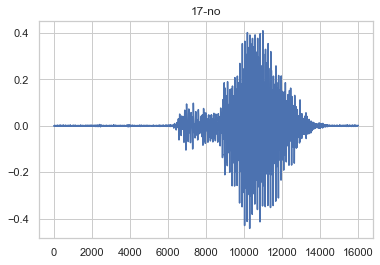

In [35]:
# Get a WAV file for inference and list of labels from the model
CNN_melspecs_tflite_quant_metadata_file = os.path.join(MODEL_PATH, "CNN_melspecs_model_quantized_metadata.tflite").replace("\\", "/")
labels = get_labels(CNN_melspecs_tflite_quant_metadata_file)
random_label = random.choice(labels)
filename = random.choice(os.listdir(os.path.join(RAW_SPEECH_PATH, random_label).replace("\\", "/")))
filename = os.path.join(RAW_SPEECH_PATH, random_label, filename).replace("\\", "/")

# Ensure the audio sample fits the model input
interpreter = tf.lite.Interpreter(model_path=str(CNN_melspecs_tflite_quant_metadata_file))
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_size = input_details[0]["shape"][1]
sample_rate = get_input_sample_rate(CNN_melspecs_tflite_quant_metadata_file)
audio_data, _ = librosa.load(filename, sr=sample_rate)
if len(audio_data) < input_size:
    audio_data.resize(input_size)

melspec = librosa.feature.melspectrogram(audio_data, sr=sample_rate, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
melspec_dB = librosa.power_to_db(melspec, ref=np.max)
melspec_dB = melspec_dB.T # transpose to keep consistency with what the CNN expects (# temporal segments, # Mel bands)

if input_details[0]["dtype"] == np.uint8:
    input_scale, input_zero_point = input_details[0]["quantization"]
    melspec_dB = melspec_dB / input_scale + input_zero_point

# Prepare data to be fed into the CNN
melspec_dB = melspec_dB[np.newaxis, ..., np.newaxis].astype(input_details[0]["dtype"])

# Run inference
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]["index"], melspec_dB)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]["index"])

# Display prediction and ground truth
top_index = np.argmax(output_data[0])
label = labels[top_index]
score = output_data[0][top_index]
print("---prediction---")
print(f"Class: {label}\nScore: {score}")
print("----truth----")
show_sample(filename)

#### Cálculo del accuracy del modelo cuantizado y comparación con el modelo normal

In [36]:
# Function to run inference on a TFLite model
def run_tflite_model(tflite_file, melspec):
    labels = get_labels(tflite_file)

    # Ensure the audio sample fits the model input
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details[0]["dtype"] == np.uint8:
        input_scale, input_zero_point = input_details[0]["quantization"]
        melspec = melspec / input_scale + input_zero_point

    # Prepare data to be fed into the CNN
    melspec = melspec[np.newaxis, ...].astype(input_details[0]["dtype"])

    # Run inference
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_details[0]["index"], melspec)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]["index"])

    # Display prediction and ground truth
    top_index = np.argmax(output_data[0])
    label = labels[top_index]
    score = output_data[0][top_index]
    
    return top_index

# Function to evaluate the TFLite model on all {set} samples
def evaluate_tflite_model(tflite_file, dataset, true_values, set_type, model_type):
    predictions = []
    truths = []

    for i in range(len(dataset)):
        value = run_tflite_model(tflite_file, dataset[i])
        predictions.append(value)
        truths.append(true_values[i])

    accuracy = sum(1 for x,y in zip(predictions, truths) if x==y)*100 / float(len(predictions))

    print("%s model accuracy is %.2f%% in %s set (Number of samples=%d)" % (model_type, accuracy, set_type, len(predictions)))

    return accuracy

In [37]:
# Quantized TFLite model on train set
acc_CNN_melspecs_tflite_quantized_train = evaluate_tflite_model(CNN_melspecs_tflite_quant_metadata_file, X_train_melspecs, y_train_melspecs, "train", "CNN melspecs quantized TFLite")

CNN melspecs quantized TFLite model accuracy is 95.46% in train set (Number of samples=42099)


In [38]:
# Quantized TFLite model on test set
acc_CNN_melspecs_tflite_quantized_test = evaluate_tflite_model(CNN_melspecs_tflite_quant_metadata_file, X_test_melspecs, y_test_melspecs, "test", "CNN melspecs quantized TFLite")

CNN melspecs quantized TFLite model accuracy is 85.90% in test set (Number of samples=12161)


Vemos que las accuracies tanto en train como en test son muy similares a las obtenidas en el modelo normal o en el modelo preparado para cuantizar. Al cuantizar lo esperable es que el accuracy se vea afectado, pero es posible que al haber mezclado el entrenamiento de un modelo preparado para cuantizar con la posterior cuantización, el accuracy se haya estabilizado y mejorado.

In [39]:
del X_train_melspecs, y_train_melspecs, X_val_melspecs, y_val_melspecs, X_test_melspecs, y_test_melspecs

-----

## 2- Datos como MFCCs

Podemos entender los MFCCs como si se tratasen de una imagen (ya que en cierto modo se pueden considerar como espectrogramas en un espacio diferente), así que podemos proceder del mismo modo que antes, generando una red neuronal con capas convolucionales.

Empezamos cargando los datos que hemos guardado previamente en el archivo json.

In [13]:
with open(os.path.join(JSON_PATH, "data_mfccs.json").replace("\\", "/"), "r") as json_file:
    data_MFCCs = json.load(json_file)

X_normal_MFCCs = np.array(data_MFCCs["MFCCs"])
y_normal_MFCCs = np.array(data_MFCCs["labels"])

with open(os.path.join(JSON_PATH, "data_mfccs_augmented.json").replace("\\", "/"), "r") as json_file:
    data_MFCCs_augmented = json.load(json_file)

X_augmented_MFCCs = np.array(data_MFCCs_augmented["MFCCs"])
y_augmented_MFCCs = np.array(data_MFCCs_augmented["labels"])

labels = [label[0] for label in data_MFCCs["mappings"]]

In [14]:
del data_MFCCs, data_MFCCs_augmented

Como tenemos los conjuntos normales y aumentados separados, tenemos que hacer un breve tratamiento para dividir correctamente los datos en train, validacion y test, teniendo en cuenta que los datos aumentados solo pueden estar en el conjunto de train.

In [15]:
test_size = 0.3
X_train_MFCCs, X_test_MFCCs, y_train_MFCCs, y_test_MFCCs = train_test_split(X_normal_MFCCs, y_normal_MFCCs, test_size=test_size, stratify=y_normal_MFCCs)

validation_size = 0.1
X_train_MFCCs, X_val_MFCCs, y_train_MFCCs, y_val_MFCCs = train_test_split(X_train_MFCCs, y_train_MFCCs, test_size=validation_size, stratify=y_train_MFCCs)

X_train_MFCCs = np.concatenate([X_train_MFCCs, X_augmented_MFCCs])
y_train_MFCCs = np.concatenate([y_train_MFCCs, y_augmented_MFCCs])

In [16]:
print("Train data:", X_train_MFCCs.shape)
print("Train labels:", y_train_MFCCs.shape)

print("Validation data:", X_val_MFCCs.shape)
print("Validation labels:", y_val_MFCCs.shape)

print("Test data:", X_test_MFCCs.shape)
print("Test labels:", y_test_MFCCs.shape)

Train data: (42099, 44, 12)
Train labels: (42099,)
Validation data: (2838, 44, 12)
Validation labels: (2838,)
Test data: (12161, 44, 12)
Test labels: (12161,)


In [17]:
del X_normal_MFCCs, y_normal_MFCCs, X_augmented_MFCCs, y_augmented_MFCCs

Ahora ajustamos las dimensiones para que estas sean coherentes con las dimensiones de entrada de la red neuronal que vamos a entrenar. Como vamos a crear una CNN tenemos que pasarle una secuencia de entrada correspondiente a los datos de la imagen (primeras 2 dimensiones) pero tenemos que añadir una dimensión extra que se refiere al número de canales que tiene la supuesta imagen. En nuestro caso solo tenemos un canal porque no estamos trabajando con una imagen como tal, así que simplemente añadimos esa dimensión.

In [18]:
X_train_MFCCs = X_train_MFCCs[..., np.newaxis]
X_val_MFCCs = X_val_MFCCs[..., np.newaxis]
X_test_MFCCs = X_test_MFCCs[..., np.newaxis]

De este modo, los datos de entrada a la red tienen las siguientes dimensiones: (# muestras por conjunto, # segmentos temporales, # MFCCs, # canales = 1). Los conjuntos de las etiquetas tienen una sola dimensión.

Ahora ya podemos pasar a construir la CNN que queremos entrenar.

### CNN normal (sin cuantizar)

Creamos una red basada en capas convolucionales. A la hora de crear el modelo tenemos en cuenta solo las capas que se pueden cuantizar, así que capas como por ejemplo la de BatchNormalization no se pueden utilizar.

In [46]:
"""
# First approach, not valid because uses layers that can't be quantized

input_shape = (X_train_MFCCs.shape[1], X_train_MFCCs.shape[2], X_train_MFCCs.shape[3])
num_labels = len(np.unique(y_train_MFCCs))

model_CNN_MFCCs = keras.Sequential()

# 1st convolutional layer
model_CNN_MFCCs.add(keras.layers.Conv2D(64, (3,3), input_shape=input_shape, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
#model_CNN_MFCCs.add(keras.layers.BatchNormalization()) # does not allow quantization
model_CNN_MFCCs.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding="same"))

# 2nd convolutional layer
model_CNN_MFCCs.add(keras.layers.Conv2D(32, (3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
#model_CNN_MFCCs.add(keras.layers.BatchNormalization()) # does not allow quantization
model_CNN_MFCCs.add(keras.layers.MaxPool2D((2,2), strides=(1,1), padding="same"))

# 3rd convolutional layer
model_CNN_MFCCs.add(keras.layers.Conv2D(16, (3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
#model_CNN_MFCCs.add(keras.layers.BatchNormalization()) # does not allow quantization
model_CNN_MFCCs.add(keras.layers.MaxPool2D((2,2), strides=(1,1), padding="same"))

# Flatten + Dense
model_CNN_MFCCs.add(keras.layers.Flatten())
model_CNN_MFCCs.add(keras.layers.Dense(32, activation="relu"))
#model_CNN_MFCCs.add(keras.layers.Dropout(0.3))  # does not allow quantization

# Final classification layer
model_CNN_MFCCs.add(keras.layers.Dense(num_labels, activation="softmax"))
"""

'\n# First approach, not valid because uses layers that can\'t be quantized\n\ninput_shape = (X_train_MFCCs.shape[1], X_train_MFCCs.shape[2], X_train_MFCCs.shape[3])\nnum_labels = len(np.unique(y_train_MFCCs))\n\nmodel_CNN_MFCCs = keras.Sequential()\n\n# 1st convolutional layer\nmodel_CNN_MFCCs.add(keras.layers.Conv2D(64, (3,3), input_shape=input_shape, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))\n#model_CNN_MFCCs.add(keras.layers.BatchNormalization()) # does not allow quantization\nmodel_CNN_MFCCs.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding="same"))\n\n# 2nd convolutional layer\nmodel_CNN_MFCCs.add(keras.layers.Conv2D(32, (3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))\n#model_CNN_MFCCs.add(keras.layers.BatchNormalization()) # does not allow quantization\nmodel_CNN_MFCCs.add(keras.layers.MaxPool2D((2,2), strides=(1,1), padding="same"))\n\n# 3rd convolutional layer\nmodel_CNN_MFCCs.add(keras.layers.Conv2D(16, (3,3), acti

In [47]:
input_shape = (X_train_MFCCs.shape[1], X_train_MFCCs.shape[2], X_train_MFCCs.shape[3])
num_labels = len(np.unique(y_train_MFCCs))

model_CNN_MFCCs = keras.Sequential()

# 1st convolutional layer
model_CNN_MFCCs.add(keras.layers.Conv2D(8, (3,3), input_shape=input_shape, activation="relu"))
model_CNN_MFCCs.add(keras.layers.MaxPool2D((2,2), strides=(1,1), padding="same"))

# 2nd convolutional layer
model_CNN_MFCCs.add(keras.layers.Conv2D(32, (3,3), activation="relu"))
model_CNN_MFCCs.add(keras.layers.MaxPool2D((2,2), strides=(1,1), padding="same"))

# 3rd convolutional layer
model_CNN_MFCCs.add(keras.layers.Conv2D(16, (3,3), activation="relu"))
model_CNN_MFCCs.add(keras.layers.MaxPool2D((2,2), strides=(1,1), padding="same"))

# Flatten + Final dense
model_CNN_MFCCs.add(keras.layers.Flatten())
model_CNN_MFCCs.add(keras.layers.Dense(25, activation="relu"))
model_CNN_MFCCs.add(keras.layers.Dense(num_labels, activation="softmax"))

model_CNN_MFCCs.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 42, 10, 8)         80        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 42, 10, 8)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 8, 32)         2336      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 40, 8, 32)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 38, 6, 16)         4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 38, 6, 16)       

In [48]:
plot_model(model_CNN_MFCCs, to_file="CNN_MFCC.png", show_shapes=True, show_dtype=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


Compilamos el modelo.

In [49]:
# Compile the model
model_CNN_MFCCs.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Entrenamos el modelo compilado.

In [50]:
earlystop_callback = keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=PATIENCE)

hist_CNN_MFCCs = model_CNN_MFCCs.fit(X_train_MFCCs, y_train_MFCCs, batch_size=50, epochs=25, validation_data=[X_val_MFCCs, y_val_MFCCs], verbose=1)

Epoch 1/25
842/842 [==============================] - 26s 30ms/step - loss: 2.3009 - accuracy: 0.2706 - val_loss: 1.3345 - val_accuracy: 0.5891
Epoch 2/25
842/842 [==============================] - 25s 30ms/step - loss: 1.0959 - accuracy: 0.6522 - val_loss: 0.8218 - val_accuracy: 0.7400
Epoch 3/25
842/842 [==============================] - 25s 30ms/step - loss: 0.7363 - accuracy: 0.7666 - val_loss: 0.6428 - val_accuracy: 0.8009
Epoch 4/25
842/842 [==============================] - 25s 30ms/step - loss: 0.5875 - accuracy: 0.8104 - val_loss: 0.5489 - val_accuracy: 0.8277
Epoch 5/25
842/842 [==============================] - 25s 30ms/step - loss: 0.5025 - accuracy: 0.8386 - val_loss: 0.5486 - val_accuracy: 0.8298
Epoch 6/25
842/842 [==============================] - 25s 30ms/step - loss: 0.4396 - accuracy: 0.8583 - val_loss: 0.5005 - val_accuracy: 0.8453
Epoch 7/25
842/842 [==============================] - 25s 29ms/step - loss: 0.3904 - accuracy: 0.8751 - val_loss: 0.4761 - val_accuracy:

Mostramos la evolución del loss y el accuracy durante el entrenamiento.

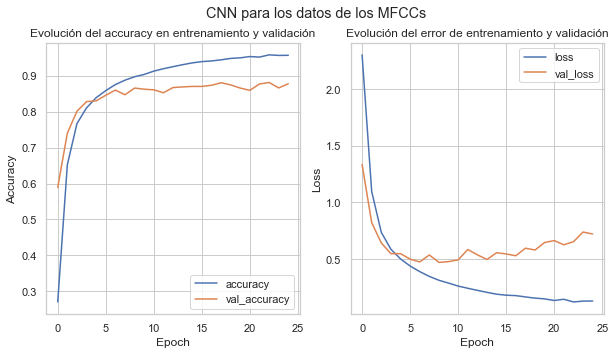

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# accuracy subplot
ax[0].plot(hist_CNN_MFCCs.history["accuracy"], label="accuracy")
ax[0].plot(hist_CNN_MFCCs.history["val_accuracy"], label="val_accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc="lower right")
ax[0].set_title("Evolución del accuracy en entrenamiento y validación")

# loss subplot
ax[1].plot(hist_CNN_MFCCs.history["loss"], label="loss")
ax[1].plot(hist_CNN_MFCCs.history["val_loss"], label="val_loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend(loc="upper right")
ax[1].set_title("Evolución del error de entrenamiento y validación")

plt.suptitle("CNN para los datos de los MFCCs")
plt.show()

Calculamos el accuracy sobre todos los conjuntos de datos (train, validacion y test) para compararlos entre ellos.

In [52]:
train_loss_CNN_MFCCs, train_acc_CNN_MFCCs = model_CNN_MFCCs.evaluate(X_train_MFCCs, y_train_MFCCs, verbose=0)
print("Accuracy en train:", train_acc_CNN_MFCCs)

Accuracy en train: 0.9714482426643372


In [53]:
val_loss_CNN_MFCCs, val_acc_CNN_MFCCs = model_CNN_MFCCs.evaluate(X_val_MFCCs, y_val_MFCCs, verbose=0)
print("Accuracy en validación:", val_acc_CNN_MFCCs)

Accuracy en validación: 0.8773784637451172


In [54]:
test_loss_CNN_MFCCs, test_acc_CNN_MFCCs = model_CNN_MFCCs.evaluate(X_test_MFCCs, y_test_MFCCs, verbose=0)
print("Accuracy en test:", test_acc_CNN_MFCCs)

Accuracy en test: 0.8780527710914612


Obtenemos unos valores del accuracy bastante elevados, pero vemos que el accuracy en train es mucho mayor que en validación y test, lo que puede indicar un cierto sobreajuste. Sin embargo, el accuracy en test es bastante bueno, así que no nos preocupa del todo.

Mostramos ahora las matrices de confusión.

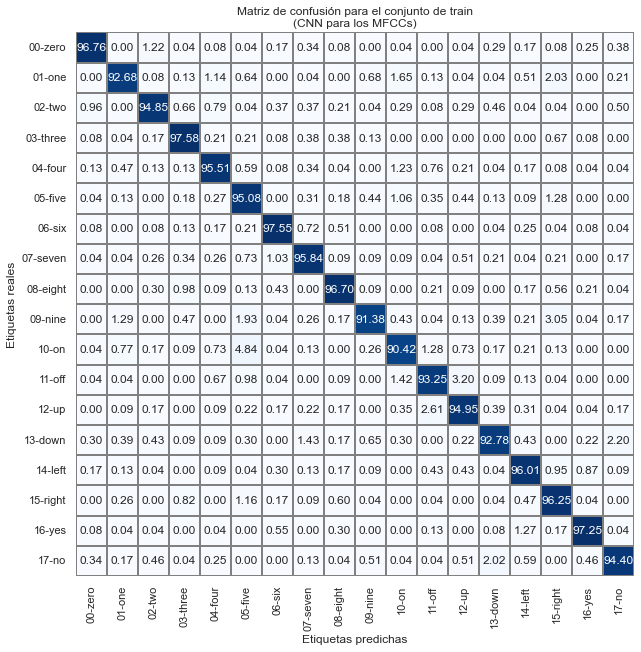

In [20]:
preds_train_CNN_MFCCs = model_CNN_MFCCs.predict(X_train_MFCCs, verbose=0)
preds_indexes_train_CNN_MFCCs = [np.argmax(pred) for pred in preds_train_CNN_MFCCs]
pos = [i+0.5 for i in range(len(labels))]

confusion_mtx_original = np.around(confusion_matrix(y_train_MFCCs, preds_indexes_train_CNN_MFCCs, normalize="true")*100, 2)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx_original, annot=True, linewidths=0.01, cmap="Blues", linecolor="gray", fmt=".2f", cbar=False, ax=ax)
plt.xlabel("Etiquetas predichas")
plt.xticks(pos, labels, rotation="vertical")
plt.ylabel("Etiquetas reales")
plt.yticks(pos, labels, rotation="horizontal")
plt.title("Matriz de confusión para el conjunto de train\n(CNN para los MFCCs)")

plt.show()

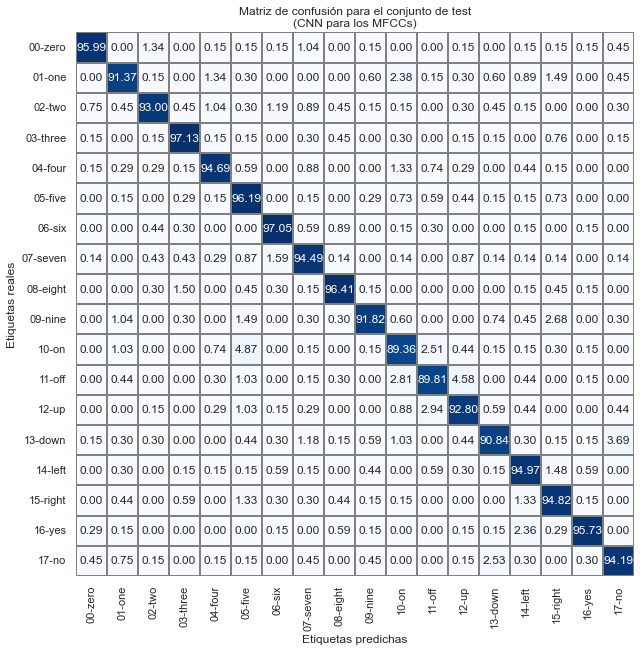

In [21]:
preds_test_CNN_MFCCs = model_CNN_MFCCs.predict(X_test_MFCCs, verbose=0)
preds_indexes_test_CNN_MFCCs = [np.argmax(pred) for pred in preds_test_CNN_MFCCs]
pos = [i+0.5 for i in range(len(labels))]

confusion_mtx_original = np.around(confusion_matrix(y_test_MFCCs, preds_indexes_test_CNN_MFCCs, normalize="true")*100, 2)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx_original, annot=True, linewidths=0.01, cmap="Blues", linecolor="gray", fmt=".2f", cbar=False, ax=ax)
plt.xlabel("Etiquetas predichas")
plt.xticks(pos, labels, rotation="vertical")
plt.ylabel("Etiquetas reales")
plt.yticks(pos, labels, rotation="horizontal")
plt.title("Matriz de confusión para el conjunto de test\n(CNN para los MFCCs)")

plt.show()

Finalmente, guardamos el modelo que hemos entrenado, en versión normal y en versión tflite.

In [57]:
#Normal
model_CNN_MFCCs.save(os.path.join(MODEL_PATH, "CNN_MFCCs.h5").replace("\\", "/"))

#TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model_CNN_MFCCs)
tflite_model = converter.convert()
with open(os.path.join(MODEL_PATH, "CNN_MFCCs.tflite").replace("\\", "/"), "wb") as f:
    f.write(tflite_model)

#### Inferencia

Probamos como llevar a cabo la inferencia en nuevas muestras, obteniendo la predicción para una muestra del conjunto de test.

In [58]:
preds = model_CNN_MFCCs.predict(X_test_MFCCs[0][np.newaxis, ...], verbose=0)
pred_index = np.argmax(preds)

print("Real:", labels[y_test_MFCCs[0]])
print("Prediccion:", labels[pred_index])

Real: 01-one
Prediccion: 01-one


Por otro lado, en caso de que se tratase de un nuevo audio que no ha sido procesado previamente (por ejemplo un audio que llega directamente a través del micrófono), sería necesario transformar la información para poder predecir sobre él.

In [59]:
n_mfcc=12
hop_length=512
n_fft=2048

for label in labels:

    # Load audio file
    filename = random.choice(os.listdir(os.path.join(RAW_SPEECH_PATH, label).replace("\\", "/")))
    filename = os.path.join(label, filename).replace("\\", "/")
    signal, sample_rate = librosa.load(os.path.join(RAW_SPEECH_PATH, filename).replace("\\", "/"), sr=COMMON_NFRAMES_LIBROSA)

    # Ensure proper length of the audio file
    if len(signal) > COMMON_NFRAMES_LIBROSA:
        signal = signal[:COMMON_NFRAMES_LIBROSA]
    
    # Get MFCCs with expected configuration
    MFCCs = librosa.feature.mfcc(signal, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    MFCCs = MFCCs.T # transpose to keep consistency with what the CNN expects (# temporal segments, # MFCCs)

    # Prepare data to be fed into the CNN
    MFCCs = MFCCs[np.newaxis, ..., np.newaxis]

    preds = model_CNN_MFCCs.predict(MFCCs, verbose=0)
    pred_index = np.argmax(preds)

    print("Real (por localización del audio):", label)
    print("Prediccion:", labels[pred_index], "\n")

Real (por localización del audio): 00-zero
Prediccion: 00-zero 

Real (por localización del audio): 01-one
Prediccion: 01-one 

Real (por localización del audio): 02-two
Prediccion: 02-two 

Real (por localización del audio): 03-three
Prediccion: 03-three 

Real (por localización del audio): 04-four
Prediccion: 04-four 

Real (por localización del audio): 05-five
Prediccion: 05-five 

Real (por localización del audio): 06-six
Prediccion: 06-six 

Real (por localización del audio): 07-seven
Prediccion: 07-seven 

Real (por localización del audio): 08-eight
Prediccion: 08-eight 

Real (por localización del audio): 09-nine
Prediccion: 09-nine 

Real (por localización del audio): 10-on
Prediccion: 10-on 

Real (por localización del audio): 11-off
Prediccion: 11-off 

Real (por localización del audio): 12-up
Prediccion: 12-up 

Real (por localización del audio): 13-down
Prediccion: 13-down 

Real (por localización del audio): 14-left
Prediccion: 14-left 

Real (por localización del audio): 

### Modelo preparado para cuantizar

Una vez tenemos el modelo ya definido, necesitamos convertirlo en un modelo cuantizado para que se pueda ejecutar en la TPU. Este proceso requiere que generemos y entrenemos un nuevo modelo con la misma estructura que el anterior, pero que esté preparado de antemano para ser cuantizado.

In [60]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware
q_aware_CNN_MFCCs = quantize_model(model_CNN_MFCCs)

# `quantize_model` requires a recompile
q_aware_CNN_MFCCs.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

q_aware_CNN_MFCCs.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_1 (QuantizeL  (None, 44, 12, 1)        3         
 ayer)                                                           
                                                                 
 quant_conv2d_3 (QuantizeWra  (None, 42, 10, 8)        99        
 pperV2)                                                         
                                                                 
 quant_max_pooling2d_3 (Quan  (None, 42, 10, 8)        1         
 tizeWrapperV2)                                                  
                                                                 
 quant_conv2d_4 (QuantizeWra  (None, 40, 8, 32)        2403      
 pperV2)                                                         
                                                                 
 quant_max_pooling2d_4 (Quan  (None, 40, 8, 32)       

In [61]:
earlystop_callback = keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=PATIENCE)

hist_q_aware_CNN_MFCC = q_aware_CNN_MFCCs.fit(X_train_MFCCs, y_train_MFCCs, batch_size=50, epochs=25, validation_data=[X_val_MFCCs, y_val_MFCCs], verbose=1)

Epoch 1/25
842/842 [==============================] - 29s 33ms/step - loss: 0.4458 - accuracy: 0.8551 - val_loss: 0.5067 - val_accuracy: 0.8693
Epoch 2/25
842/842 [==============================] - 27s 33ms/step - loss: 0.1675 - accuracy: 0.9425 - val_loss: 0.5617 - val_accuracy: 0.8742
Epoch 3/25
842/842 [==============================] - 28s 33ms/step - loss: 0.1429 - accuracy: 0.9507 - val_loss: 0.6324 - val_accuracy: 0.8629
Epoch 4/25
842/842 [==============================] - 27s 33ms/step - loss: 0.1377 - accuracy: 0.9551 - val_loss: 0.6320 - val_accuracy: 0.8791
Epoch 5/25
842/842 [==============================] - 27s 33ms/step - loss: 0.1270 - accuracy: 0.9576 - val_loss: 0.6784 - val_accuracy: 0.8756
Epoch 6/25
842/842 [==============================] - 27s 33ms/step - loss: 0.1303 - accuracy: 0.9569 - val_loss: 0.7171 - val_accuracy: 0.8672
Epoch 7/25
842/842 [==============================] - 27s 33ms/step - loss: 0.1208 - accuracy: 0.9599 - val_loss: 0.7460 - val_accuracy:

Vemos como se comporta el modelo preparado para ser cuantizado en los conjuntos de train, validación y test.

In [62]:
train_loss_q_aware_CNN_MFCCs, train_acc_q_aware_CNN_MFCCs = q_aware_CNN_MFCCs.evaluate(X_train_MFCCs, y_train_MFCCs, verbose=0)
print("Accuracy en train:", train_acc_q_aware_CNN_MFCCs)

Accuracy en train: 0.9601891040802002


In [63]:
val_loss_q_aware_CNN_MFCCs, val_acc_q_aware_CNN_MFCCs = q_aware_CNN_MFCCs.evaluate(X_val_MFCCs, y_val_MFCCs, verbose=0)
print("Accuracy en validación:", val_acc_q_aware_CNN_MFCCs)

Accuracy en validación: 0.8608174920082092


In [64]:
test_loss_q_aware_CNN_MFCCs, test_acc_q_aware_CNN_MFCCs = q_aware_CNN_MFCCs.evaluate(X_test_MFCCs, y_test_MFCCs, verbose=0)
print("Accuracy en test:", test_acc_q_aware_CNN_MFCCs)

Accuracy en test: 0.8664583563804626


Obtenemos que los valores del accuracy para el modelo cuantizado son prácticamente idénticos a los valores del modelo normal.

### Cuantización y conversión a TFLite

Una vez tenemos el modelo preparado para cuantizar, procedemos a cuantizarlo y transformarlo en un modelo TFLite que pueda ser ejecutado en la TPU.

*Como la TPU solo puede ejecutar modelos que estén completamente cuantizados con enteros, vamos a proceder como si se tratase de una post-cuantización pero utilizando el modelo que se ha preparado para cuantizar, por si eso mejorase los resultados.

In [65]:
def representative_data_gen():
    for i in random.sample(range(X_train_MFCCs.shape[0]), 10000):
        yield [X_train_MFCCs[i][np.newaxis, ...].astype("float32")]

converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_CNN_MFCCs)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

quantized_tflite_CNN_MFCCs = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Carlos\AppData\Local\Temp\tmp8hetb_vx\assets


INFO:tensorflow:Assets written to: C:\Users\Carlos\AppData\Local\Temp\tmp8hetb_vx\assets
c:\Users\Carlos\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Verificamos que las entradas y salidas del modelo son del tipo int8, indicando que la cuantización es completa a enteros para que se pueda ejecutar en la TPU.

In [66]:
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_CNN_MFCCs)
input_type = interpreter.get_input_details()[0]["dtype"]
print("input: ", input_type)
output_type = interpreter.get_output_details()[0]["dtype"]
print("output: ", output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


Guardamos este modelo cuantizado en un archivo .tflite.

In [67]:
import pathlib

print(f"Exporting the quantized model to {MODEL_PATH}")
tflite_models_dir = pathlib.Path(MODEL_PATH)
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the quantized model
tflite_quant_file_CNN_MFCCs = tflite_models_dir/"CNN_MFCCs_model_quantized.tflite" # working because it's a pathlib path object
tflite_quant_file_CNN_MFCCs.write_bytes(quantized_tflite_CNN_MFCCs)

Exporting the quantized model to ./models/Simple_models/


106272

Ahora volvemos a guardar el modelo cuantizado, incluyendo en el los metadatos necesarios para que esté totalmente completo y sea independiente y funcional por sí mismo.

In [68]:
from tflite_support.metadata_writers import audio_classifier
from tflite_support.metadata_writers import metadata_info
from tflite_support.metadata_writers import writer_utils

AudioClassifierWriter = audio_classifier.MetadataWriter
_MODEL_PATH = "./models/Simple_models/CNN_MFCCs_model_quantized.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "./models/Simple_models/labels.txt"
# Expected sampling rate of the input audio buffer.
_SAMPLE_RATE = COMMON_NFRAMES_LIBROSA
# Expected number of channels of the input audio buffer. Note, Task library only support single channel so far.
_CHANNELS = 1
_SAVE_TO_PATH = "./models/Simple_models/CNN_MFCCs_model_quantized_metadata.tflite"

# Create the metadata writer.
writer = AudioClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), _SAMPLE_RATE, _CHANNELS, [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "AudioClassifier",
  "description": "Identify the most prominent type in the audio clip from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "audio_clip",
          "description": "Input audio clip to be classified.",
          "content": {
            "content_properties_type": "AudioProperties",
            "content_properties": {
              "sample_rate": 22050,
              "channels": 1
            }
          },
          "stats": {
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "probability",
          "description": "Scores of the labels respectively.",
          "content": {
            "content_properties_type": "FeatureProperties",
            "content_properties": {
            }
          },
          "stats": {
            "max": [
              255.0
            ],
            "min": [
              0.0
            ]
          },
        

#### Inferencia

Utilizamos el modelo que contiene los metadatos para la inferencia.

In [69]:
from tflite_support import metadata
import json

def get_labels(model):
    """Returns a list of labels, extracted from the model metadata."""
    displayer = metadata.MetadataDisplayer.with_model_file(model)
    labels_file = displayer.get_packed_associated_file_list()[0]
    labels = displayer.get_associated_file_buffer(labels_file).decode()
    return [line.strip() for line in labels.split("\n")]

def get_input_sample_rate(model):
    """Returns the model's expected sample rate, from the model metadata."""
    displayer = metadata.MetadataDisplayer.with_model_file(model)
    metadata_json = json.loads(displayer.get_metadata_json())
    input_tensor_metadata = metadata_json["subgraph_metadata"][0]["input_tensor_metadata"][0]
    input_content_props = input_tensor_metadata["content"]["content_properties"]
    return input_content_props["sample_rate"]

def show_sample(audio_path):
    audio_data, sample_rate = sf.read(audio_path)
    class_name = os.path.basename(os.path.dirname(audio_path))
    print(f"Class: {class_name}")
    print(f"File: {audio_path}")

    plt.title(class_name)
    plt.plot(audio_data)
    display(IPython.display.Audio(audio_data, rate=sample_rate))

---prediction---
Class: 14-left
Score: 255
----truth----
Class: 14-left
File: ./data/raw/speech_commands/14-left/8a5acefd_nohash_2.wav


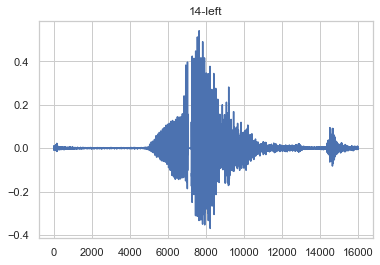

In [70]:
# Get a WAV file for inference and list of labels from the model
CNN_MFCCs_tflite_quant_metadata_file = os.path.join(MODEL_PATH, "CNN_MFCCs_model_quantized_metadata.tflite").replace("\\", "/")
labels = get_labels(CNN_MFCCs_tflite_quant_metadata_file)
random_label = random.choice(labels)
filename = random.choice(os.listdir(os.path.join(RAW_SPEECH_PATH, random_label).replace("\\", "/")))
filename = os.path.join(RAW_SPEECH_PATH, random_label, filename).replace("\\", "/")

# Ensure the audio sample fits the model input
interpreter = tf.lite.Interpreter(model_path=str(CNN_MFCCs_tflite_quant_metadata_file))
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_size = input_details[0]["shape"][1]
sample_rate = get_input_sample_rate(CNN_MFCCs_tflite_quant_metadata_file)
audio_data, _ = librosa.load(filename, sr=sample_rate)
if len(audio_data) < input_size:
    audio_data.resize(input_size)

MFCCs = librosa.feature.mfcc(audio_data, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
MFCCs = MFCCs.T # transpose to keep consistency with what the CNN expects (# temporal segments, # MFCCs)

if input_details[0]["dtype"] == np.uint8:
    input_scale, input_zero_point = input_details[0]["quantization"]
    MFCCs = MFCCs / input_scale + input_zero_point

# Prepare data to be fed into the CNN
MFCCs = MFCCs[np.newaxis, ..., np.newaxis].astype(input_details[0]["dtype"])

# Run inference
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]["index"], MFCCs)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]["index"])

# Display prediction and ground truth
top_index = np.argmax(output_data[0])
label = labels[top_index]
score = output_data[0][top_index]
print("---prediction---")
print(f"Class: {label}\nScore: {score}")
print("----truth----")
show_sample(filename)

#### Cálculo del accuracy del modelo cuantizado y comparación con el modelo normal

In [71]:
# Function to run inference on a TFLite model
def run_tflite_model(tflite_file, MFCCs):
    labels = get_labels(tflite_file)

    # Ensure the audio sample fits the model input
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details[0]["dtype"] == np.uint8:
        input_scale, input_zero_point = input_details[0]["quantization"]
        MFCCs = MFCCs / input_scale + input_zero_point

    # Prepare data to be fed into the CNN
    MFCCs = MFCCs[np.newaxis, ...].astype(input_details[0]["dtype"])

    # Run inference
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_details[0]["index"], MFCCs)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]["index"])

    # Display prediction and ground truth
    top_index = np.argmax(output_data[0])
    label = labels[top_index]
    score = output_data[0][top_index]
    
    return top_index

# Function to evaluate the TFLite model on all {set} samples
def evaluate_tflite_model(tflite_file, dataset, true_values, set_type, model_type):
    predictions = []
    truths = []

    for i in range(len(dataset)):
        value = run_tflite_model(tflite_file, dataset[i])
        predictions.append(value)
        truths.append(true_values[i])

    accuracy = sum(1 for x,y in zip(predictions, truths) if x==y)*100 / float(len(predictions))

    print("%s model accuracy is %.2f%% in %s set (Number of samples=%d)" % (model_type, accuracy, set_type, len(predictions)))

    return accuracy

In [72]:
# Quantized TFLite model on train set
acc_CNN_MFCCs_tflite_quantized_train = evaluate_tflite_model(CNN_MFCCs_tflite_quant_metadata_file, X_train_MFCCs, y_train_MFCCs, "train", "CNN MFCCs quantized TFLite")

CNN MFCCs quantized TFLite model accuracy is 93.74% in train set (Number of samples=42099)


In [73]:
# Quantized TFLite model on test set
acc_CNN_MFCCs_tflite_quantized_test = evaluate_tflite_model(CNN_MFCCs_tflite_quant_metadata_file, X_test_MFCCs, y_test_MFCCs, "test", "CNN MFCCs quantized TFLite")

CNN MFCCs quantized TFLite model accuracy is 86.23% in test set (Number of samples=12161)


Vemos que las accuracies tanto en train como en test son muy similares a las obtenidas en el modelo normal o en el modelo preparado para cuantizar. Al cuantizar lo esperable es que el accuracy se vea afectado, pero es posible que al haber mezclado el entrenamiento de un modelo preparado para cuantizar con la posterior cuantización, el accuracy se haya estabilizado y mejorado.

In [74]:
del X_train_MFCCs, y_train_MFCCs, X_val_MFCCs, y_val_MFCCs, X_test_MFCCs, y_test_MFCCs

-----

## 3- Datos puros de la señal

Empezamos cargando los datos que hemos guardado previamente en los archivos npy (inicialmente se guardaron en un json pero por falta de memoria en la carga hubo que volverlos a guardar como arrays de numpy).

In [5]:
X_normal_raws = np.load(os.path.join(JSON_PATH, "X_normal_raws.npy").replace("\\", "/"))
y_normal_raws = np.load(os.path.join(JSON_PATH, "y_normal_raws.npy").replace("\\", "/"))
X_augmented_raws = np.load(os.path.join(JSON_PATH, "X_augmented_raws.npy").replace("\\", "/"))
y_augmented_raws = np.load(os.path.join(JSON_PATH, "y_augmented_raws.npy").replace("\\", "/"))

Como tenemos los conjuntos normales y aumentados separados, tenemos que hacer un breve tratamiento para dividir correctamente los datos en train, validacion y test, teniendo en cuenta que los datos aumentados solo pueden estar en el conjunto de train.

In [6]:
test_size = 0.3
X_train_raws, X_test_raws, y_train_raws, y_test_raws = train_test_split(X_normal_raws, y_normal_raws, test_size=test_size, stratify=y_normal_raws)

validation_size = 0.1
X_train_raws, X_val_raws, y_train_raws, y_val_raws = train_test_split(X_train_raws, y_train_raws, test_size=validation_size, stratify=y_train_raws)

X_train_raws = np.concatenate([X_train_raws, X_augmented_raws])
y_train_raws = np.concatenate([y_train_raws, y_augmented_raws])

In [7]:
print("Train data:", X_train_raws.shape)
print("Train labels:", y_train_raws.shape)

print("Validation data:", X_val_raws.shape)
print("Validation labels:", y_val_raws.shape)

print("Test data:", X_test_raws.shape)
print("Test labels:", y_test_raws.shape)

Train data: (42099, 4410)
Train labels: (42099,)
Validation data: (2838, 4410)
Validation labels: (2838,)
Test data: (12161, 4410)
Test labels: (12161,)


In [8]:
del X_normal_raws, y_normal_raws, X_augmented_raws, y_augmented_raws

Ahora ajustamos las dimensiones para que estas sean coherentes con las dimensiones de entrada de la red neuronal que vamos a entrenar. En un primer momento se consideró crear un modelo con capas densas, pudiendo incluir alguna recurrente, pero por falta de memoria y capacidad de procesamiento, y también porque las estructuras que se investigaron sobreajustaban demasiado los datos sin llegar a aprender, se decidió enfocar el problema con redes convolucionales 1D. Como vamos a crear una CNN tenemos que pasarle una secuencia de entrada correspondiente a los datos crudos de entrada (primera dimensión) pero tenemos que añadir una dimensión extra que se refiere al número de canales que supuestamente tenemos. En nuestro caso solo tenemos un canal, así que simplemente añadimos esa dimensión.

In [9]:
X_train_raws = X_train_raws[..., np.newaxis]
X_val_raws = X_val_raws[..., np.newaxis]
X_test_raws = X_test_raws[..., np.newaxis]

De este modo, los datos de entrada a la red tienen las siguientes dimensiones: (# muestras por conjunto, valores crudos de las señales, # canales = 1). Los conjuntos de las etiquetas tienen una sola dimensión.

Ahora ya podemos pasar a construir la CNN que queremos entrenar.

### CNN normal (sin cuantizar)

Creamos una red basada en capas convolucionales, en este caso 1D. Somos conscientes de que no se va a poder entrenar un modelo preparado para cuantizarlo, sino que directamente habrá que hacer un post-cuantizado porque las capas convolucionales 1D no se pueden cuantizar. Sin embargo, esta estructura de red es la única que proporcionaba resultados decentes.

In [9]:
input_shape = (X_train_raws.shape[1], X_train_raws.shape[2])
num_labels = len(np.unique(y_train_raws))

model_CNN_raws = keras.Sequential()

# 1st convolutional layer
model_CNN_raws.add(keras.layers.Conv1D(32, kernel_size=41, input_shape=input_shape, activation="relu"))
model_CNN_raws.add(keras.layers.MaxPooling1D(21, strides=10)) # strides=20

# 2nd convolutional layer
model_CNN_raws.add(keras.layers.Conv1D(16, kernel_size=11, activation="relu"))
model_CNN_raws.add(keras.layers.MaxPooling1D(11, strides=5))

# 3rd convolutional layer
model_CNN_raws.add(keras.layers.Conv1D(16, kernel_size=5, activation="relu"))
model_CNN_raws.add(keras.layers.MaxPooling1D(5, strides=2)) #3

# 4th convolutional layer
model_CNN_raws.add(keras.layers.Conv1D(8, kernel_size=3, activation="relu"))
model_CNN_raws.add(keras.layers.MaxPooling1D(3, strides=2)) #3

model_CNN_raws.add(keras.layers.Flatten())
model_CNN_raws.add(keras.layers.Dense(30, activation="relu"))
model_CNN_raws.add(keras.layers.Dense(num_labels, activation="softmax"))

model_CNN_raws.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4370, 32)          1344      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 435, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 425, 16)           5648      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 83, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 79, 16)            1296      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 38, 16)           0

In [10]:

plot_model(model_CNN_raws, to_file="CNN_raws.png", show_shapes=True, show_dtype=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


Compilamos el modelo.

In [11]:
# Compile the model
model_CNN_raws.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Entrenamos el modelo compilado.

In [12]:
earlystop_callback = keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=PATIENCE)

hist_CNN_raws = model_CNN_raws.fit(X_train_raws, y_train_raws, batch_size=50, epochs=75, validation_data=[X_val_raws, y_val_raws], verbose=1)
# En este caso fijams un número mucho mayor de epochs, porque se ha visto durante el entrenamiento que éste es mucho más lento pero poco a poco mejora hasta estancarse en la epoch ~80

Epoch 1/75
842/842 [==============================] - 94s 110ms/step - loss: 2.2875 - accuracy: 0.2530 - val_loss: 1.7469 - val_accuracy: 0.4426
Epoch 2/75
842/842 [==============================] - 114s 136ms/step - loss: 1.5296 - accuracy: 0.5148 - val_loss: 1.3525 - val_accuracy: 0.5719
Epoch 3/75
842/842 [==============================] - 98s 116ms/step - loss: 1.2831 - accuracy: 0.5924 - val_loss: 1.2375 - val_accuracy: 0.5923
Epoch 4/75
842/842 [==============================] - 94s 112ms/step - loss: 1.1677 - accuracy: 0.6254 - val_loss: 1.1085 - val_accuracy: 0.6409
Epoch 5/75
842/842 [==============================] - 99s 118ms/step - loss: 1.0902 - accuracy: 0.6503 - val_loss: 1.0301 - val_accuracy: 0.6741
Epoch 6/75
842/842 [==============================] - 94s 112ms/step - loss: 1.0196 - accuracy: 0.6709 - val_loss: 0.9868 - val_accuracy: 0.6945
Epoch 7/75
842/842 [==============================] - 97s 116ms/step - loss: 0.9791 - accuracy: 0.6827 - val_loss: 1.1038 - val_a

Mostramos la evolución del loss y el accuracy durante el entrenamiento.

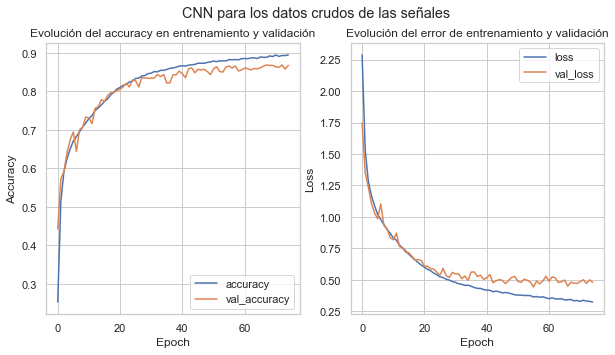

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# accuracy subplot
ax[0].plot(hist_CNN_raws.history["accuracy"], label="accuracy")
ax[0].plot(hist_CNN_raws.history["val_accuracy"], label="val_accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc="lower right")
ax[0].set_title("Evolución del accuracy en entrenamiento y validación")

# loss subplot
ax[1].plot(hist_CNN_raws.history["loss"], label="loss")
ax[1].plot(hist_CNN_raws.history["val_loss"], label="val_loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend(loc="upper right")
ax[1].set_title("Evolución del error de entrenamiento y validación")

plt.suptitle("CNN para los datos crudos de las señales")
plt.show()

Calculamos el accuracy sobre todos los conjuntos de datos (train, validacion y test) para compararlos entre ellos.

In [14]:
train_loss_CNN_raws, train_acc_CNN_raws = model_CNN_raws.evaluate(X_train_raws, y_train_raws, verbose=0)
print("Accuracy en train:", train_acc_CNN_raws)

Accuracy en train: 0.9049383401870728


In [15]:
val_loss_CNN_raws, val_acc_CNN_raws = model_CNN_raws.evaluate(X_val_raws, y_val_raws, verbose=0)
print("Accuracy en validación:", val_acc_CNN_raws)

Accuracy en validación: 0.8675123453140259


In [16]:
test_loss_CNN_raws, test_acc_CNN_raws = model_CNN_raws.evaluate(X_test_raws, y_test_raws, verbose=0)
print("Accuracy en test:", test_acc_CNN_raws)

Accuracy en test: 0.871638834476471


De entre todos los modelos que se han ido probando, este es con diferencia el que mejores resultados ha dado, siendo aún así bastante peores que los obtenidos con los otros planteamientos. Esto es así porque de los datos brutos es más difícil extraer información relevante para el problema en cuestión. Sin embargo, este es el enfoque más directo, así que consideramos que los resultados son buenos, siendo la estructura de la red tan simple y con tan pocos parámetros de entrenamiento.

Mostramos ahora las matrices de confusión.

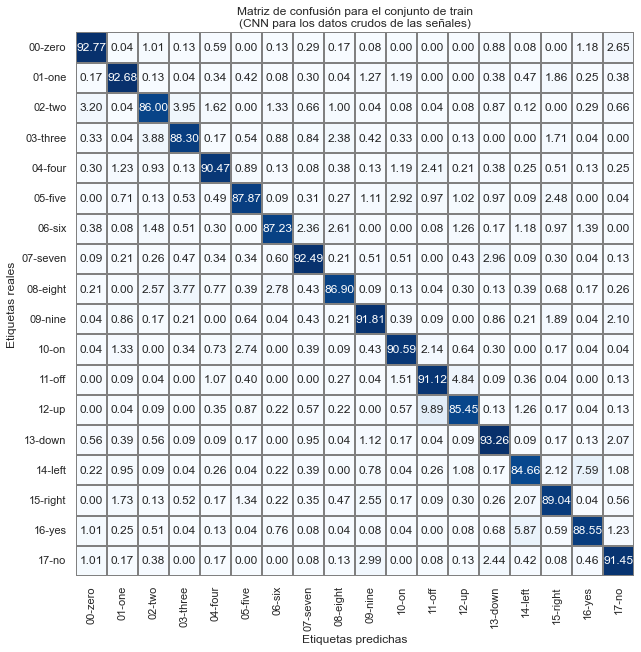

In [11]:
preds_train_CNN_raws = model_CNN_raws.predict(X_train_raws, verbose=0)
preds_indexes_train_CNN_raws = [np.argmax(pred) for pred in preds_train_CNN_raws]
pos = [i+0.5 for i in range(len(labels))]

confusion_mtx_CNN_raws_train = np.around(confusion_matrix(y_train_raws, preds_indexes_train_CNN_raws, normalize="true")*100, 2)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx_CNN_raws_train, annot=True, linewidths=0.01, cmap="Blues", linecolor="gray", fmt=".2f", cbar=False, ax=ax)
plt.xlabel("Etiquetas predichas")
plt.xticks(pos, labels, rotation="vertical")
plt.ylabel("Etiquetas reales")
plt.yticks(pos, labels, rotation="horizontal")
plt.title("Matriz de confusión para el conjunto de train\n(CNN para los datos crudos de las señales)")

plt.show()

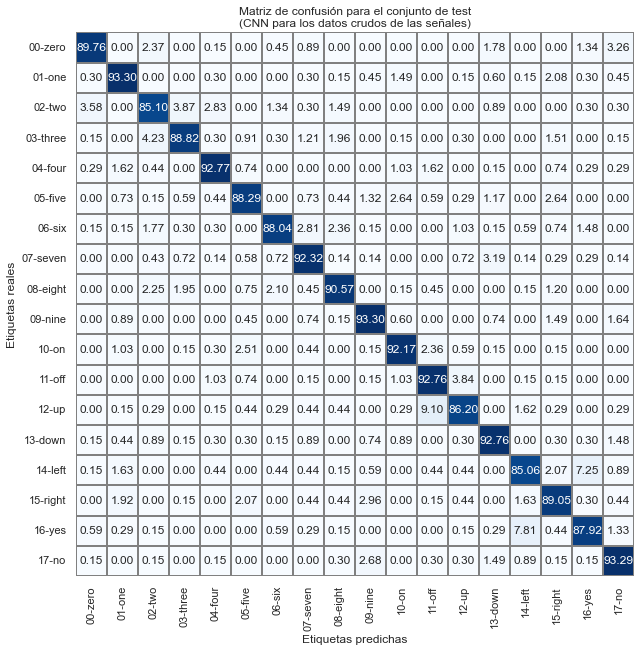

In [12]:
preds_test_CNN_raws = model_CNN_raws.predict(X_test_raws, verbose=0)
preds_indexes_test_CNN_raws = [np.argmax(pred) for pred in preds_test_CNN_raws]
pos = [i+0.5 for i in range(len(labels))]

confusion_mtx_CNN_raws_test = np.around(confusion_matrix(y_test_raws, preds_indexes_test_CNN_raws, normalize="true")*100, 2)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx_CNN_raws_test, annot=True, linewidths=0.01, cmap="Blues", linecolor="gray", fmt=".2f", cbar=False, ax=ax)
plt.xlabel("Etiquetas predichas")
plt.xticks(pos, labels, rotation="vertical")
plt.ylabel("Etiquetas reales")
plt.yticks(pos, labels, rotation="horizontal")
plt.title("Matriz de confusión para el conjunto de test\n(CNN para los datos crudos de las señales)")

plt.show()

Finalmente, guardamos el modelo que hemos entrenado, en versión normal y en versión tflite.

In [19]:
#Normal
model_CNN_raws.save(os.path.join(MODEL_PATH, "CNN_raws.h5").replace("\\", "/"))

#TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model_CNN_raws)
tflite_model = converter.convert()
with open(os.path.join(MODEL_PATH, "CNN_raws.tflite").replace("\\", "/"), "wb") as f:
    f.write(tflite_model)

#### Inferencia

Probamos como llevar a cabo la inferencia en nuevas muestras, obteniendo la predicción para una muestra del conjunto de test.

In [20]:
preds = model_CNN_raws.predict(X_test_raws[0][np.newaxis, ...], verbose=0)
pred_index = np.argmax(preds)

print("Real:", labels[y_test_raws[0]])
print("Prediccion:", labels[pred_index])

Real: 17-no
Prediccion: 17-no


Por otro lado, en caso de que se tratase de un nuevo audio que no ha sido procesado previamente (por ejemplo un audio que llega directamente a través del micrófono), sería necesario transformar la información para poder predecir sobre él.

In [21]:
downsampled_sample_rate = int(COMMON_NFRAMES_LIBROSA/5) # divide by 5 to leave the number of frames around 4k, so that the the final file won't be huge

for label in labels:

    # Load audio file
    filename = random.choice(os.listdir(os.path.join(RAW_SPEECH_PATH, label).replace("\\", "/")))
    filename = os.path.join(label, filename).replace("\\", "/")
    signal, sample_rate = librosa.load(os.path.join(RAW_SPEECH_PATH, filename).replace("\\", "/"), sr=downsampled_sample_rate)

    # Ensure proper length of the audio file
    if len(signal) > downsampled_sample_rate:
        signal = signal[:downsampled_sample_rate]

    # Prepare data to be fed into the CNN
    signal = signal[np.newaxis, ..., np.newaxis]

    preds = model_CNN_raws.predict(signal, verbose=0)
    pred_index = np.argmax(preds)

    print("Real (por localización del audio):", label)
    print("Prediccion:", labels[pred_index], "\n")

Real (por localización del audio): 00-zero
Prediccion: 00-zero 

Real (por localización del audio): 01-one
Prediccion: 07-seven 

Real (por localización del audio): 02-two
Prediccion: 02-two 

Real (por localización del audio): 03-three
Prediccion: 03-three 

Real (por localización del audio): 04-four
Prediccion: 11-off 

Real (por localización del audio): 05-five
Prediccion: 05-five 

Real (por localización del audio): 06-six
Prediccion: 06-six 

Real (por localización del audio): 07-seven
Prediccion: 07-seven 

Real (por localización del audio): 08-eight
Prediccion: 08-eight 

Real (por localización del audio): 09-nine
Prediccion: 09-nine 

Real (por localización del audio): 10-on
Prediccion: 10-on 

Real (por localización del audio): 11-off
Prediccion: 11-off 

Real (por localización del audio): 12-up
Prediccion: 11-off 

Real (por localización del audio): 13-down
Prediccion: 13-down 

Real (por localización del audio): 14-left
Prediccion: 14-left 

Real (por localización del audio)

### Cuantización y conversión a TFLite

En este caso no tenemos un modelo preparado para cuantizar, sino que únicamente tenemos el modelo normal entrenado, por lo que tendremos que hacer directamente una post-cuantización. Como las capas convolucionales a priori no son válidas, no lo podremos ejecutar directamente en la TPU. Por otro lado, como no estamos preparando un modelo para cuantizarlo sino que directamente estamos cuantizando el modelo entrenado, no es necesario tener que entrenar de nuevo otro modelo.

*Independientemente de que se pueda ejecutar el modelo cuantizado en una TPU o no, vamos a realizar la cuantización completamente a enteros (como en los casos anteriores) para estar en igualdad de condiciones para comparar los resultados y para aumentar las posibilidades de ejecutarlo en la TPU, o que en la CPU consuma menos recursos.

In [23]:
def representative_data_gen():
    for i in random.sample(range(X_train_raws.shape[0]), 10000):
        yield [X_train_raws[i][np.newaxis, ...].astype("float32")]

converter = tf.lite.TFLiteConverter.from_keras_model(model_CNN_raws)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

quantized_tflite_CNN_raws = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Carlos\AppData\Local\Temp\tmpm2myuqzw\assets


INFO:tensorflow:Assets written to: C:\Users\Carlos\AppData\Local\Temp\tmpm2myuqzw\assets
c:\Users\Carlos\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Verificamos que las entradas y salidas del modelo son del tipo int8, indicando que la cuantización es completa a enteros para que se pueda ejecutar en la TPU.

In [24]:
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_CNN_raws)
input_type = interpreter.get_input_details()[0]["dtype"]
print("input: ", input_type)
output_type = interpreter.get_output_details()[0]["dtype"]
print("output: ", output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


Guardamos este modelo cuantizado en un archivo .tflite.

In [25]:
import pathlib

print(f"Exporting the quantized model to {MODEL_PATH}")
tflite_models_dir = pathlib.Path(MODEL_PATH)
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the quantized model
tflite_quant_file_CNN_raws = tflite_models_dir/"CNN_raws_model_quantized.tflite" # working because it's a pathlib path object
tflite_quant_file_CNN_raws.write_bytes(quantized_tflite_CNN_raws)

Exporting the quantized model to ./models/Simple_models/


25680

Ahora volvemos a guardar el modelo cuantizado, incluyendo en el los metadatos necesarios para que esté totalmente completo y sea independiente y funcional por sí mismo.

In [26]:
from tflite_support.metadata_writers import audio_classifier
from tflite_support.metadata_writers import metadata_info
from tflite_support.metadata_writers import writer_utils

AudioClassifierWriter = audio_classifier.MetadataWriter
_MODEL_PATH = "./models/Simple_models/CNN_raws_model_quantized.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "./models/Simple_models/labels.txt"
# Expected sampling rate of the input audio buffer.
_SAMPLE_RATE = downsampled_sample_rate
# Expected number of channels of the input audio buffer. Note, Task library only support single channel so far.
_CHANNELS = 1
_SAVE_TO_PATH = "./models/Simple_models/CNN_raws_model_quantized_metadata.tflite"

# Create the metadata writer.
writer = AudioClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), _SAMPLE_RATE, _CHANNELS, [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "AudioClassifier",
  "description": "Identify the most prominent type in the audio clip from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "audio_clip",
          "description": "Input audio clip to be classified.",
          "content": {
            "content_properties_type": "AudioProperties",
            "content_properties": {
              "sample_rate": 4410,
              "channels": 1
            }
          },
          "stats": {
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "probability",
          "description": "Scores of the labels respectively.",
          "content": {
            "content_properties_type": "FeatureProperties",
            "content_properties": {
            }
          },
          "stats": {
            "max": [
              255.0
            ],
            "min": [
              0.0
            ]
          },
         

#### Inferencia

Utilizamos el modelo que contiene los metadatos para la inferencia.

In [27]:
from tflite_support import metadata
import json

def get_labels(model):
    """Returns a list of labels, extracted from the model metadata."""
    displayer = metadata.MetadataDisplayer.with_model_file(model)
    labels_file = displayer.get_packed_associated_file_list()[0]
    labels = displayer.get_associated_file_buffer(labels_file).decode()
    return [line.strip() for line in labels.split("\n")]

def get_input_sample_rate(model):
    """Returns the model's expected sample rate, from the model metadata."""
    displayer = metadata.MetadataDisplayer.with_model_file(model)
    metadata_json = json.loads(displayer.get_metadata_json())
    input_tensor_metadata = metadata_json["subgraph_metadata"][0]["input_tensor_metadata"][0]
    input_content_props = input_tensor_metadata["content"]["content_properties"]
    return input_content_props["sample_rate"]

def show_sample(audio_path):
    audio_data, sample_rate = sf.read(audio_path)
    class_name = os.path.basename(os.path.dirname(audio_path))
    print(f"Class: {class_name}")
    print(f"File: {audio_path}")

    plt.title(class_name)
    plt.plot(audio_data)
    display(IPython.display.Audio(audio_data, rate=sample_rate))

---prediction---
Class: 17-no
Score: 255
----truth----
Class: 17-no
File: ./data/raw/speech_commands/17-no/6736bc64_nohash_1.wav


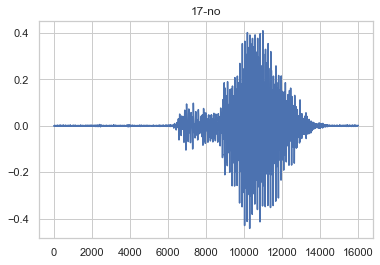

In [28]:
# Get a WAV file for inference and list of labels from the model
CNN_raws_tflite_quant_metadata_file = os.path.join(MODEL_PATH, "CNN_raws_model_quantized_metadata.tflite").replace("\\", "/")
labels = get_labels(CNN_raws_tflite_quant_metadata_file)
random_label = random.choice(labels)
filename = random.choice(os.listdir(os.path.join(RAW_SPEECH_PATH, random_label).replace("\\", "/")))
filename = os.path.join(RAW_SPEECH_PATH, random_label, filename).replace("\\", "/")

# Ensure the audio sample fits the model input
interpreter = tf.lite.Interpreter(model_path=str(CNN_raws_tflite_quant_metadata_file))
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_size = input_details[0]["shape"][1]
sample_rate = get_input_sample_rate(CNN_raws_tflite_quant_metadata_file)
audio_data, _ = librosa.load(filename, sr=sample_rate)
if len(audio_data) < input_size:
    audio_data.resize(input_size)

if input_details[0]["dtype"] == np.uint8:
    input_scale, input_zero_point = input_details[0]["quantization"]
    audio_data = audio_data / input_scale + input_zero_point

# Prepare data to be fed into the CNN
audio_data = audio_data[np.newaxis, ..., np.newaxis].astype(input_details[0]["dtype"])

# Run inference
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]["index"], audio_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]["index"])

# Display prediction and ground truth
top_index = np.argmax(output_data[0])
label = labels[top_index]
score = output_data[0][top_index]
print("---prediction---")
print(f"Class: {label}\nScore: {score}")
print("----truth----")
show_sample(filename)

#### Cálculo del accuracy del modelo cuantizado y comparación con el modelo normal

In [29]:
# Function to run inference on a TFLite model
def run_tflite_model(tflite_file, signal):
    labels = get_labels(tflite_file)

    # Ensure the audio sample fits the model input
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details[0]["dtype"] == np.uint8:
        input_scale, input_zero_point = input_details[0]["quantization"]
        signal = signal / input_scale + input_zero_point

    # Prepare data to be fed into the CNN
    signal = signal[np.newaxis, ...].astype(input_details[0]["dtype"])

    # Run inference
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_details[0]["index"], signal)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]["index"])

    # Display prediction and ground truth
    top_index = np.argmax(output_data[0])
    label = labels[top_index]
    score = output_data[0][top_index]
    
    return top_index

# Function to evaluate the TFLite model on all {set} samples
def evaluate_tflite_model(tflite_file, dataset, true_values, set_type, model_type):
    predictions = []
    truths = []

    for i in range(len(dataset)):
        value = run_tflite_model(tflite_file, dataset[i])
        predictions.append(value)
        truths.append(true_values[i])

    accuracy = sum(1 for x,y in zip(predictions, truths) if x==y)*100 / float(len(predictions))

    print("%s model accuracy is %.2f%% in %s set (Number of samples=%d)" % (model_type, accuracy, set_type, len(predictions)))

    return accuracy

In [30]:
# Quantized TFLite model on train set
acc_CNN_raws_tflite_quantized_train = evaluate_tflite_model(CNN_raws_tflite_quant_metadata_file, X_train_raws, y_train_raws, "train", "CNN raws quantized TFLite")

CNN raws quantized TFLite model accuracy is 83.82% in train set (Number of samples=42099)


In [31]:
# Quantized TFLite model on test set
acc_CNN_raws_tflite_quantized_test = evaluate_tflite_model(CNN_raws_tflite_quant_metadata_file, X_test_raws, y_test_raws, "test", "CNN raws quantized TFLite")

CNN raws quantized TFLite model accuracy is 80.75% in test set (Number of samples=12161)


Vemos que en este caso las accuracies tanto en train como en test han disminuido ligeramente con respecto al modelo original sin cuantizar. El cierto que el empeoramiento no es exagerado, pero es notable. De este modo confirmamos como el hecho de no preparar el modelo para cuantizarlo empeora los resultados obtenidos con el modelo cuantizado.

In [32]:
del X_train_raws, y_train_raws, X_val_raws, y_val_raws, X_test_raws, y_test_raws